# Adaptive Logistic or Exponential Forecast for Vulnerability Sightings
This notebook fetches sightings from Vulnerability Lookup, analyzes the trend, and performs forecasting using either a **logistic model** (growth) or **exponential decay** (decline), selected automatically.

In [8]:
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

## Method Overview

| Step                | Description                                                                           |
| ------------------- | ------------------------------------------------------------------------------------- |
| **Trend detection** | Checks if recent sightings are increasing or decreasing (via linear slope).           |
| **Model selection** | Uses **logistic** if slope > 0, else **exponential decay**.                           |
| **Curve fitting**   | Uses `scipy.optimize.curve_fit` to estimate parameters.                               |
| **Forecasting**     | Extends the model 10 days into the future.                                            |
| **Plotting**        | Shows observed data, forecast, and forecast region.                                   |

In [9]:
vuln_id = input('Vulnerability id: ')

In [10]:
per_page = 1000
page = 1
sightings = []

while True:
    url = f"https://vulnerability.circl.lu/api/sighting?page={page}&per_page={per_page}&vuln_id={vuln_id}"
    response = requests.get(url, headers={"accept": "application/json"})
    data = response.json()
    sightings.extend(data['data'])
    total = data['metadata']['count']
    if page * per_page >= total:
        break
    page += 1
print(f'Fetched {len(sightings)} sightings.')

Fetched 51 sightings.


In [11]:
df_sightings = pd.DataFrame(sightings)
df_sightings.head()

,uuid,creation_timestamp,type,source,vulnerability,author
0,a61a7dca-0d8f-436c-bd06-8cc2e4f4f1a5,2025-11-19T02:16:49.555493+00:00,seen,https://bsky.app/profile/pmloik.bsky.social/po...,CVE-2025-62215,{'login': 'automation'}
1,d18dde7d-8d96-4811-9cb2-58be3d1357ba,2025-11-18T19:11:03+00:00,seen,MISP/3c19819c-1dac-4ef2-bfed-be5efa7e0123,CVE-2025-62215,{'login': 'automation'}
2,2cde8365-22bd-44e4-b600-911b8637505a,2025-11-18T02:17:06.432232+00:00,seen,https://bsky.app/profile/pmloik.bsky.social/po...,CVE-2025-62215,{'login': 'automation'}
3,ffdc790f-1df6-415c-97b5-7c37fd2a4b69,2025-11-17T02:18:31.841884+00:00,seen,https://bsky.app/profile/pmloik.bsky.social/po...,CVE-2025-62215,{'login': 'automation'}
4,4a87ef86-6b25-497a-b1a6-f0f4a0b36370,2025-11-17T01:59:40.131161+00:00,seen,https://bsky.app/profile/innovatopia.bsky.soci...,CVE-2025-62215,{'login': 'automation'}


In [12]:
df_sightings['creation_date'] = pd.to_datetime(
    df_sightings['creation_timestamp'], utc=True, errors='coerce'
).dt.date

daily_counts = df_sightings.groupby('creation_date').size().rename('sightings')
daily_series = daily_counts.sort_index()
daily_series.index = pd.to_datetime(daily_series.index)
daily_series

creation_date
2025-11-11     4
2025-11-12    24
2025-11-13    11
2025-11-14     2
2025-11-17     2
2025-11-18     1
2025-11-19     1
Name: sightings, dtype: int64

In [13]:
def logistic(t, L, k, t0):
    return L / (1 + np.exp(-k * (t - t0)))

def exp_decay(t, a, b, c):
    return a * np.exp(-b * t) + c

In [14]:
t = np.arange(len(daily_series))
y = daily_series.values

if len(y) < 3:
    raise ValueError('Not enough data points for fitting.')

In [15]:
trend_slope = np.polyfit(t, y, 1)[0]
model_type = 'logistic' if trend_slope > 0 else 'decay'
print(f'Trend slope: {trend_slope:.3f}')
print(f'Selected model: {model_type}')

Trend slope: -2.286
Selected model: decay


In [16]:
try:
    if model_type == 'logistic':
        popt, _ = curve_fit(
            logistic, t, y,
            p0=[max(y)*1.5, 0.3, np.median(t)],
            bounds=([0, 0, 0], [np.inf, np.inf, np.inf]), maxfev=10000
        )
        forecast_func = lambda tt: logistic(tt, *popt)
    else:
        popt, _ = curve_fit(
            exp_decay, t, y,
            p0=[max(y), 0.3, min(y)],
            bounds=([0, 0, 0], [np.inf, np.inf, np.inf]), maxfev=10000
        )
        forecast_func = lambda tt: exp_decay(tt, *popt)
except RuntimeError:
    raise RuntimeError('Curve fitting failed.')

In [17]:
future_steps = 15
last_date = daily_series.index.max()

forecast_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=future_steps, freq='D')
t_future = np.arange(len(t), len(t) + future_steps)
forecast_future_values = np.maximum(forecast_func(t_future), 0)

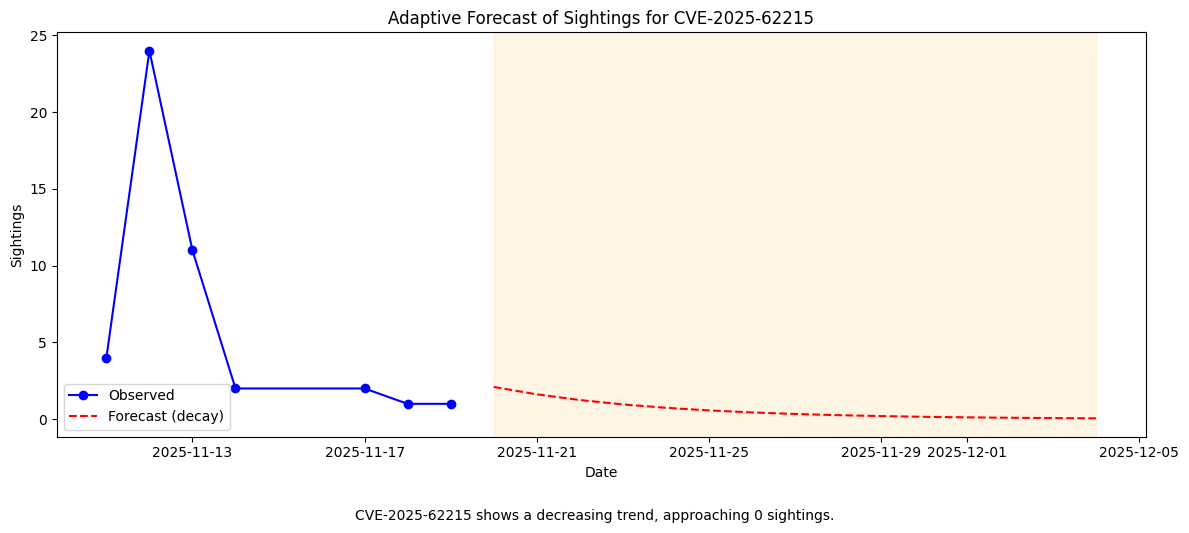

In [18]:
plt.figure(figsize=(12, 5))
plt.plot(daily_series.index, daily_series.values, 'bo-', label='Observed')
plt.plot(forecast_dates, forecast_future_values, 'r--', label=f'Forecast ({model_type})')
plt.axvspan(forecast_dates[0], forecast_dates[-1], color='orange', alpha=0.1)
plt.title(f'Adaptive Forecast of Sightings for {vuln_id}')
plt.xlabel('Date')
plt.ylabel('Sightings')
plt.legend()
summary = (f"{vuln_id} shows a rising trend, expected to plateau around {popt[0]:.0f} sightings." if model_type=='logistic'
           else f"{vuln_id} shows a decreasing trend, approaching {popt[2]:.0f} sightings.")
plt.figtext(0.5, -0.05, summary, ha='center')
plt.tight_layout()
plt.show()